Nb fichiers musique trouvés : 1
Nb fichiers podcasts trouvés : 1

=== UPDATE MECHANISM ===
Nouveaux exports détectés : 0

Clés chargées dans dfs : ['Musique', 'Podcasts']
Fichier inferences détecté : data\Inferences.json
Nb total de tags: 357

=== SKIP RATE (MUSIQUE) ===
Seuil skip : < 90s
Total écoutes (musique) : 4079
Skips : 1591
Taux de skip : 39.0%

=== Musique ===
Lignes: 4079
Total écoute: 183.7 h
Période: 2025-01-09 13:24:00 → 2026-01-07 16:10:00

Top artistes (heures):
artistName
Avenged Sevenfold        52.090513
結束バンド                    21.482152
Slash                    15.993661
Walking Papers           10.494555
Foo Fighters              9.646598
Alice In Chains           9.456162
Alter Bridge              8.279909
Rival Sons                7.627886
Red Hot Chili Peppers     5.632162
Three Days Grace          5.121494
Name: msPlayed, dtype: float64

=== Podcasts ===
Lignes: 511
Total écoute: 169.3 h
Période: 2025-01-10 01:39:00 → 2025-12-27 14:57:00

Top podcasts (heures)

<Figure size 640x480 with 0 Axes>

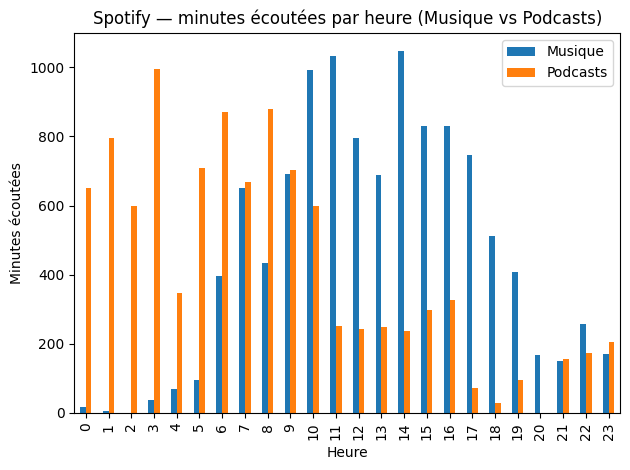


Démographie (estimée): ['male', 'age_21-24', 'student']
Types de contenus: ['audiobooks', 'music', 'podcasts_news-and-politics', 'podcasts', 'podcasts_sports-and-recreation', 'podcasts_games', 'podcasts_business-and-technology', 'music_alternative', 'audiobooks_nonfiction', 'podcasts_lifestyle-and-health'] 

Top thèmes d’intérêt (comptage de tags):


,count
business-and-finance,56
technology-and-computing,17
academic-interests,10
hobbies-and-interests,9
personal-finance,7
family-and-relationships,7
careers,5
video-gaming,5
education,4
healthy-living,4


<Figure size 640x480 with 0 Axes>

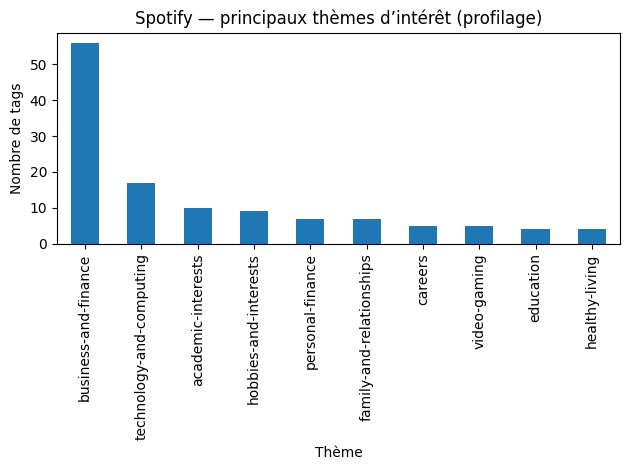


Nb tags restreints: 9
Exemples: ['3P_POL_Engaged_US [Restricted Use]', '3P_Gambling_Enthusiasts_US [Restricted Use]', '1P_Custom_Windows_Users [Advertiser-Restricted]', '1P_Custom_Samsung_Loyalists [Advertiser-Restricted]', '1P_Custom_Samsung_Podcast_Streamers [Advertiser-Restricted]']


'Profil estimé: male, age_21-24, student. Thèmes dominants: business-and-finance, technology-and-computing, academic-interests.'

In [2]:
# Mettre ses fichiers "StreamingHistory_music*.json", "StreamingHistory*podcast*.json", "inferences*.json"
# à côté du notebook OU sur le Bureau (à la racine du Bureau pour que ce soit rapide)

import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict

# --- 1) Détection des fichiers (rapide : notebook + racine du Bureau) ---

search_dirs = [Path("."),Path("data"), Path.home() / "Desktop"]

def find_all(patterns):
    """Trouve TOUS les fichiers qui matchent patterns dans les dossiers de search_dirs (sans sous-dossiers)."""
    hits = []
    for d in search_dirs:
        for p in patterns:
            hits.extend(d.glob(p))  # pas rglob => rapide
    # dédoublonne et trie par date de modification (ancien -> récent)
    return sorted(set(hits), key=lambda x: x.stat().st_mtime)

# Tous les exports musique/podcasts (update mechanism: si tu ajoutes un nouveau fichier, il sera pris)
music_files = find_all([
    "StreamingHistory_music*.json",
    "StreamingHistoryMusic*.json",
    "StreamingHistory*music*.json",
])

podcast_files = find_all([
    "StreamingHistory_podcast*.json",
    "StreamingHistoryPodcast*.json",
    "StreamingHistory*podcast*.json",
])

print("Nb fichiers musique trouvés :", len(music_files))
print("Nb fichiers podcasts trouvés :", len(podcast_files))

if not music_files and not podcast_files:
    raise FileNotFoundError(
        "Aucun fichier StreamingHistory (music/podcast) trouvé.\n"
        "Mets-les dans le même dossier que le notebook ou à la racine du Bureau."
    )

# --- 2) Chargement robuste ---

def load_spotify_streaming(path: Path) -> pd.DataFrame:
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    df = pd.DataFrame(data)

    if "endTime" not in df.columns or "msPlayed" not in df.columns:
        raise KeyError(f"{path.name}: colonnes attendues introuvables. Colonnes: {list(df.columns)}")

    df["endTime"] = pd.to_datetime(df["endTime"], errors="coerce")
    df["msPlayed"] = pd.to_numeric(df["msPlayed"], errors="coerce").fillna(0)
    df = df.dropna(subset=["endTime"]).copy()
    return df

def load_many(files):
    """Charge plusieurs fichiers et concatène. Ignore ceux qui posent problème."""
    frames = []
    for f in files:
        try:
            df = load_spotify_streaming(f)
            df["source_file"] = f.name
            frames.append(df)
        except Exception as e:
            print(f"⚠️ Fichier ignoré (erreur): {f.name} -> {e}")
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

# --- 2bis) Update mechanism : détecter nouveaux exports depuis la dernière exécution ---

STATE_PATH = Path("analysis_state.json")

def file_fingerprint(path: Path) -> str:
    st = path.stat()
    return f"{path.name}:{st.st_size}:{int(st.st_mtime)}"

def load_state():
    if STATE_PATH.exists():
        return json.loads(STATE_PATH.read_text(encoding="utf-8"))
    return {"seen": []}

def save_state(state):
    STATE_PATH.write_text(json.dumps(state, indent=2), encoding="utf-8")

def detect_new_files(all_files):
    state = load_state()
    seen = set(state.get("seen", []))

    current = [file_fingerprint(f) for f in all_files]
    new = [fp for fp in current if fp not in seen]

    state["seen"] = current
    save_state(state)
    return new

all_exports = music_files + podcast_files
new_files = detect_new_files(all_exports)

print("\n=== UPDATE MECHANISM ===")
print("Nouveaux exports détectés :", len(new_files))
if new_files:
    print("Exemples :", new_files[:5])

# --- 3) Charger et construire dfs (Musique/Podcasts) ---

dfs = {}

df_music_all = load_many(music_files)
if not df_music_all.empty:
    subset = ["endTime", "msPlayed"]
    if "trackName" in df_music_all.columns:
        subset.append("trackName")
    if "artistName" in df_music_all.columns:
        subset.append("artistName")
    df_music_all = df_music_all.drop_duplicates(subset=subset).copy()
    dfs["Musique"] = df_music_all

df_podcast_all = load_many(podcast_files)
if not df_podcast_all.empty:
    subset = ["endTime", "msPlayed"]
    if "episodeName" in df_podcast_all.columns:
        subset.append("episodeName")
    if "podcastName" in df_podcast_all.columns:
        subset.append("podcastName")
    df_podcast_all = df_podcast_all.drop_duplicates(subset=subset).copy()
    dfs["Podcasts"] = df_podcast_all

print("\nClés chargées dans dfs :", list(dfs.keys()))

# --- 4) Détection + chargement inferences (inferences.json ou inferences*.json) ---

inf_candidates = find_all(["inferences.json", "inferences*.json"])
inf_path = inf_candidates[-1] if inf_candidates else None  # le plus récent

if inf_path is None:
    raise FileNotFoundError("inferences.json / inferences*.json introuvable. Mets-le à côté du notebook ou à la racine du Bureau.")

print("Fichier inferences détecté :", inf_path)

with inf_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

if "inferences" not in data:
    raise KeyError(f"Clé 'inferences' introuvable. Clés dispo: {list(data.keys())}")

inferences = data["inferences"]
print("Nb total de tags:", len(inferences))


# --- 3bis) Taux de skip (musique) ---

SKIP_THRESHOLD_SECONDS = 90            # Seuil en secondes pour considérer une écoute comme un skip

if "Musique" in dfs and len(dfs["Musique"]) > 0:
    df_music = dfs["Musique"].copy()   # Copie des données musique

    df_music["seconds_played"] = df_music["msPlayed"] / 1000  
    # Conversion du temps écouté de millisecondes en secondes

    df_music["is_skip"] = df_music["seconds_played"] < SKIP_THRESHOLD_SECONDS  
    # Marque comme skip les écoutes trop courtes

    total_tracks = len(df_music)       # Nombre total d’écoutes
    skipped_tracks = int(df_music["is_skip"].sum())  # Nombre de skips
    skip_rate = skipped_tracks / total_tracks * 100  # Pourcentage de skips

    print("\n=== SKIP RATE (MUSIQUE) ===")
    print(f"Seuil skip : < {SKIP_THRESHOLD_SECONDS}s")
    print(f"Total écoutes (musique) : {total_tracks}")
    print(f"Skips : {skipped_tracks}")
    print(f"Taux de skip : {skip_rate:.1f}%")
else:
    print("\n donnée 'Musique' trouvée pour calculer le taux de skip.")

# --- 4) Résumé + top 10 + graphique par heure ---

def summarize(df: pd.DataFrame, label: str):
    total_h = df["msPlayed"].sum() / 3_600_000  
    # Temps total écouté en heures

    start, end = df["endTime"].min(), df["endTime"].max()  
    # Période couverte par les données

    print(f"\n=== {label} ===")
    print(f"Lignes: {len(df)}")
    print(f"Total écoute: {total_h:.1f} h")
    print(f"Période: {start} → {end}")

    # Top artistes si la colonne existe
    if "artistName" in df.columns:
        top = (
            df.groupby("artistName")["msPlayed"].sum()
              .sort_values(ascending=False)
              .head(10) / 3_600_000
        )
        print("\nTop artistes (heures):")
        print(top)

    # Top podcasts si la colonne existe
    if "podcastName" in df.columns:
        top = (
            df.groupby("podcastName")["msPlayed"].sum()
              .sort_values(ascending=False)
              .head(10) / 3_600_000
        )
        print("\nTop podcasts (heures):")
        print(top)

# Applique le résumé à musique et podcasts
for label, df in dfs.items():
    summarize(df, label)

# --- 5) Comparaison Musique vs Podcasts : activité par heure ---

hourly = {}                            # Dictionnaire pour stocker les stats horaires

for label, df in dfs.items():
    h = (
        df.assign(hour=df["endTime"].dt.hour)  # Extrait l’heure de fin d’écoute
          .groupby("hour")["msPlayed"].sum()   # Somme par heure
          .reindex(range(24), fill_value=0)    # Force les 24 heures
          / 60_000                             # Conversion en minutes
    )
    hourly[label] = h                  # Stocke le résultat

hourly_df = pd.DataFrame(hourly).fillna(0)  
# Combine musique et podcasts dans un DataFrame

plt.figure()                           # Crée une nouvelle figure
hourly_df.plot(kind="bar")             # Graphique en barres
plt.title("Spotify — minutes écoutées par heure (Musique vs Podcasts)")
plt.xlabel("Heure")
plt.ylabel("Minutes écoutées")
plt.tight_layout()
plt.show()



# --- Séparer les familles de tags ---

interests = [t.replace("interest_", "") for t in inferences if t.startswith("interest_")]
contents = [t.replace("content_", "") for t in inferences if t.startswith("content_")]
demographics = [t.replace("demographic_", "") for t in inferences if t.startswith("demographic_")]

print("\nDémographie (estimée):", demographics if demographics else "—")
print("Types de contenus:", contents[:10], ("..." if len(contents) > 10 else ""))

# --- Grouper les intérêts par thème principal ---

interest_groups = defaultdict(int)     # Dictionnaire avec compteur automatique

for it in interests:
    main_theme = it.split("_")[0] if "_" in it else it  # Thème principal
    interest_groups[main_theme] += 1    # Incrémente le compteur

df_interest_groups = (
    pd.DataFrame.from_dict(interest_groups, orient="index", columns=["count"])
      .sort_values("count", ascending=False)
)

print("\nTop thèmes d’intérêt (comptage de tags):")
display(df_interest_groups.head(10))

# --- Graphique Top 10 des intérêts ---

plt.figure()
df_interest_groups.head(10).plot(kind="bar", legend=False)
plt.title("Spotify — principaux thèmes d’intérêt (profilage)")
plt.xlabel("Thème")
plt.ylabel("Nombre de tags")
plt.tight_layout()
plt.show()

# --- Tags restreints ---

restricted_tags = [
    t for t in inferences if ("DO_NOT_USE" in t or "Restricted" in t)
]

print("\nNb tags restreints:", len(restricted_tags))
print("Exemples:", restricted_tags[:5])

# --- Résumé final du profil ---

top_themes = list(df_interest_groups.head(3).index)  # Top 3 thèmes
summary = (
    f"Profil estimé: {', '.join(demographics) if demographics else 'N/A'}. "
    f"Thèmes dominants: {', '.join(top_themes)}."
)

summary                               # Affiche le résumé final
